# ACCESS-OM3 and ACCESS-OM2 horizontal mean temperature and salinity Hovmollers: drift from initial condition, vs depth and time

Related issue: https://github.com/ACCESS-Community-Hub/access-om3-25km-paper-1/issues/8

Run with a lot of cores (say, 28).

In [2]:
#parameters

### USER EDIT start
# esm_file='/g/data/ol01/access-om3-output/access-om3-025/MC_25km_jra_ryf-1.0-beta/experiment_datastore.json'
# esm_file='/g/data/ol01/access-om3-output/access-om3-025/25km-iaf-test-for-AK-expt-7df5ef4c/datastore.json'
esm_file='/g/data/ol01/outputs/access-om3-25km/MC_25km_jra_iaf-1.0-beta-5165c0f8/datastore.json'
dpi=150
### USER EDIT stop

import os
from matplotlib import rcParams
%matplotlib inline
rcParams['figure.dpi']= dpi

plotfolder=f"/g/data/{os.environ['PROJECT']}/{os.environ['USER']}/access-om3-paper-1/notebooks/"
os.makedirs(plotfolder, exist_ok=True)

# needed for mkmd START 
notebooks_dir = os.path.join(f"/g/data/{os.environ['PROJECT']}/{os.environ['USER']}/access-om3-paper-1", "notebooks")
os.makedirs(notebooks_dir, exist_ok=True)
os.chdir(notebooks_dir)
print("Changed working directory to:", os.getcwd())
try:
    from mkfigs_configdoc import mkmd,get_notebook_name
    notebook_name=get_notebook_name(notebook_name)
except ModuleNotFoundError:
    notebook_name='not_using_mkfigs.sh'
## example usage (note if the first argument to mkmd remains the same, you can insert multiple figures from the same notebook): 
#if notebook_name!='not_using_mkfigs.sh': plt.savefig(plotfolder+'mkmd/'+notebook_name[:-6]+'1.png', dpi=300, bbox_inches='tight')
#if notebook_name!='not_using_mkfigs.sh': mkmd("Template notebook","`"+notebook_name+"`: Example figure 1 of ACCESS-OM3 sea surface height (m).",os.path.basename(os.path.dirname(esm_file)),notebook_name[:-6]+'1.png',plotfolder+'mkmd/')
#if notebook_name!='not_using_mkfigs.sh': mkmd("Template notebook","`"+notebook_name+"`: Example figure 2 of ACCESS-OM3 sea surface height (m).",os.path.basename(os.path.dirname(esm_file)),notebook_name[:-6]+'2.png',plotfolder+'mkmd/')
# needed for mkmd STOP

 # a similar cell under this means it's being run in batch
print("ESM datastore path: ",esm_file)
print("Plot folder path: ",plotfolder)

Changed working directory to: /g/data/x77/aek156/access-om3-paper-1/notebooks
ESM datastore path:  /g/data/ol01/outputs/access-om3-25km/MC_25km_jra_iaf-1.0-beta-5165c0f8/datastore.json
Plot folder path:  /g/data/x77/aek156/access-om3-paper-1/notebooks/


In [3]:
IAF = esm_file.find('iaf') > 0
IAF

True

In [4]:
import os
import numpy as np
import xarray as xr
import cftime
import cf_xarray as cfxr
import cf_xarray.units
import pint_xarray
from pint import application_registry as ureg
import intake
import matplotlib.pyplot as plt
from matplotlib.patches import Patch
import matplotlib as mpl
from distributed import Client
import cmocean as cm
import cartopy.crs as ccrs
import cartopy.feature as cft
from shapely import geometry
from textwrap import wrap
from tqdm.notebook import tqdm
xr.set_options(keep_attrs=True);  # cf_xarray works best when xarray keeps attributes by default

In [5]:
import warnings
warnings.simplefilter(action='ignore', category=FutureWarning)

In [6]:
client = Client(threads_per_worker=1)
client

/g/data/xp65/public/apps/med_conda/envs/analysis3-26.01/lib/python3.11/site-packages/distributed/node.py:187: UserWarning: Port 8787 is already in use.
Perhaps you already have a cluster running?
Hosting the HTTP server on port 41787 instead
  warnings.warn(


Connection method: Cluster object,Cluster type: distributed.LocalCluster
Dashboard: /proxy/41787/status,
Dashboard: /proxy/41787/status,Workers: 14
Total threads: 14,Total memory: 63.00 GiB
Status: running,Using processes: True
Comm: tcp://127.0.0.1:45683,Workers: 0
Dashboard: /proxy/41787/status,Total threads: 0
Started: Just now,Total memory: 0 B
Comm: tcp://127.0.0.1:41663,Total threads: 1
Dashboard: /proxy/35217/status,Memory: 4.50 GiB
Nanny: tcp://127.0.0.1:45757,


## Define regions

Text(0.5, 1.0, 'Regions (BUG: incorrect shapes north of 65°N)')

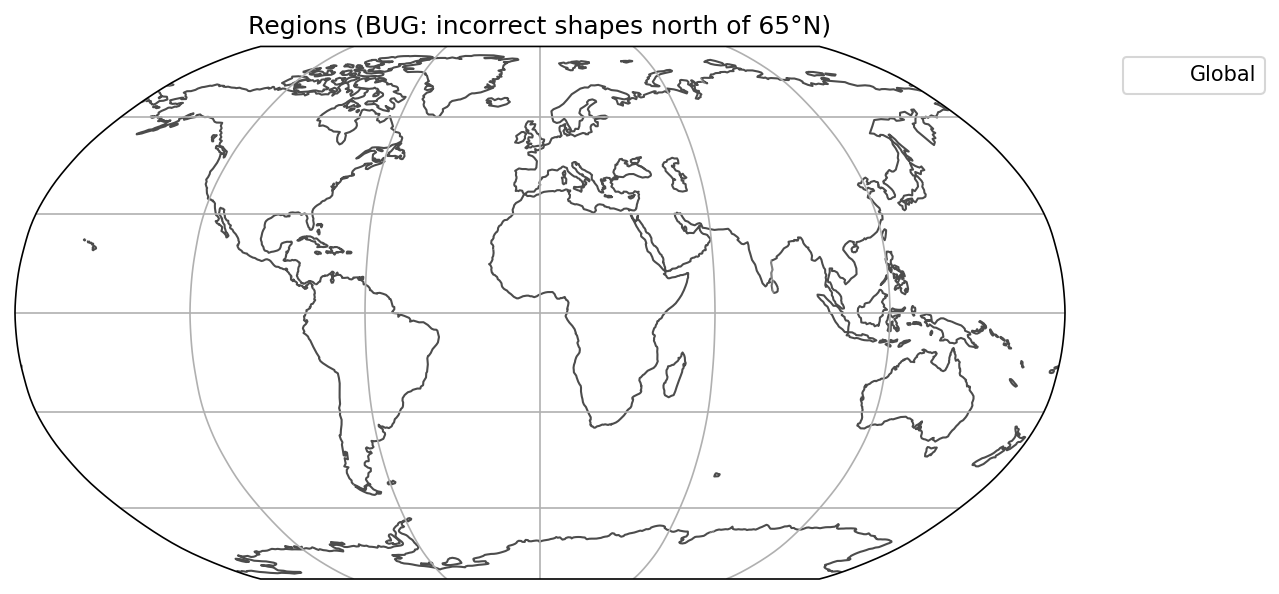

In [7]:
regions = { # [minx, maxx, miny, maxy], using model longitude range (-280 to 80)
    "Global": [-280, 80, -90, 90],
    # "Arctic": [-280, 80, 65, 90],
    # "Southern Ocean": [-280, 80, -82, -63],
    # "ACC": [-280, 80, -63, -45],
    # "Southern Pacific": [-210, -70, -45, -20],
    # "Tropical Pacific": [-240, -100, -20, 20],
    # "North Pacific": [-240, -100, 20, 65],
    # "South Atlantic": [-60, 20, -45, -20],
    # "Tropical Atlantic": [-70, 20, -20, 20],
    # "North Atlantic": [-100, 0, 20, 65],
    # "Indian": [30, 120, -45, 20],
    # "Aegean Sea": [18, 27.5, 34, 44],
    # "Black Sea": [27.5, 43, 40.5, 48],
    # "Baltic Sea": [13, 30, 53, 58],
    # "Mediterranean Sea": [0, 35, 31, 41],
    # "Red Sea": [33, 44, 12, 29],
    # "Persian Gulf": [47, 56, 24, 31],
    # "White Sea": [31, 41, 63, 68],
}
regions = {k: dict(zip(["minx", "maxx", "miny", "maxy"], v)) for k, v in regions.items()}  # convert to dicts

for r, d in regions.items():
    for k, x in d.items():
        if k in ["minx", "maxx"] and x != max(-280, min(x, 80)):
            raise ValueError(f"{r} {k} = {x} is outside the range -280 to 80")

fig = plt.figure(figsize=(10, 4))

colors = mpl.color_sequences['tab20']
try:  # set Global color to white 
    colors[list(regions.keys()).index("Global")] = (1, 1, 1)
except ValueError:
    pass

ax = plt.axes(position=[0.05,0.05,0.7,0.9], projection=ccrs.Robinson())
ax.coastlines(resolution="110m")
ax.gridlines(draw_labels=False)

legend_elements = []
for i, (region, limits) in enumerate(regions.items()):
    ax.add_geometries([geometry.box(**limits)], crs=ccrs.PlateCarree(), color=colors[i], alpha=0.3)
    legend_elements.append(Patch(color=colors[i], alpha=0.3, label=region))

ax.legend(handles=legend_elements, bbox_to_anchor=(1.2, 1.00))
plt.title("Regions (BUG: incorrect shapes north of 65°N)")

## Load data from ACCESS-OM3

In [7]:
catalogs = [
                esm_file,
                # '/g/data/ol01/outputs/access-om3-25km/MC_25km_jra_iaf-1.0-beta-gm1-d968c801/datastore.json',
                # '/g/data/ol01/outputs/access-om3-25km/MC_25km_jra_iaf-1.0-beta-gm2-5dc49da6/datastore.json',
                # '/g/data/ol01/outputs/access-om3-25km/MC_25km_jra_iaf-1.0-beta-gm3-da330542/datastore.json',
                # '/g/data/ol01/outputs/access-om3-25km/MC_25km_jra_iaf-1.0-beta-gm4-9fd08880/datastore.json',
                # '/g/data/ol01/outputs/access-om3-25km/MC_25km_jra_iaf-1.0-beta-gm5-9b5dbfa9/datastore.json',
                # '/g/data/ol01/access-om3-output/access-om3-025/25km-iaf-test-for-AK-expt-7df5ef4c/datastore.json',
            ]
catalogs

['/g/data/ol01/outputs/access-om3-25km/MC_25km_jra_iaf-1.0-beta-5165c0f8/datastore.json']

In [8]:
om3datastores = { os.path.normpath(c).split(os.sep)[-2]:
               intake.open_esm_datastore(c,
                                         columns_with_iterables=[
                                            "variable",
                                            "variable_long_name",
                                            "variable_standard_name",
                                            "variable_cell_methods",
                                            "variable_units"]
                                        )
              for c in catalogs }
om3datastores

{'MC_25km_jra_iaf-1.0-beta-5165c0f8': <datastore catalog with 22 dataset(s) from 6042 asset(s)>}

In [9]:
om3varnames = [ 'thetao', 'so' ]

om3vars = {
    vname: {expt: ds.search(variable=vname).to_dask(
                xarray_open_kwargs = dict(
                    chunks={"xh": -1, "yh": -1, "z_l": -1},  # remove "yh": -1 for resolution finer than 25km 
                    decode_timedelta=True
                )
            )[vname]
            for expt, ds in om3datastores.items()
          }
    for vname in om3varnames
    }

# omit latitudes with grid bug in this run https://github.com/ACCESS-NRI/ocean_model_grid_generator/issues/7
for vname, d in om3vars.items():
    try:
        d['25km-iaf-test-for-AK-expt-7df5ef4c'] = d['25km-iaf-test-for-AK-expt-7df5ef4c'].isel(yh=slice(10, None))
    except ValueError:
        d['25km-iaf-test-for-AK-expt-7df5ef4c'] = d['25km-iaf-test-for-AK-expt-7df5ef4c'].isel(yq=slice(10, None))
    except KeyError:
        pass

if IAF:
    for vname, d in om3vars.items():
        for expt in d:
            try:
                d[expt] = d[expt].convert_calendar("proleptic_gregorian", use_cftime=True)
            except KeyError:
                pass

## Load data from ACCESS-OM2
use control - see https://forum.access-hive.org.au/t/access-om2-control-experiments/258#p-747-ryf-7

In [10]:
if IAF:
    om2exptname = '025deg_jra55_iaf_omip2_cycle1'
else:
    om2exptname = '025deg_jra55_ryf9091_gadi'  # monthly temp only for 1900-1903, and 2300-, with annual data in the gap
om2datastores = {om2exptname: intake.cat.access_nri[om2exptname]}

In [11]:
om2varnames = [ 'temp', 'salt' ]

om2vars = {
    vname: {expt: ds.search(variable=vname, frequency="1mon").to_dask(
                xarray_open_kwargs = dict(
                    chunks={"xt_ocean": -1, "yt_ocean": -1, "st_ocean" : -1},  # remove "yt_ocean": -1 for resolution finer than 25km
                    decode_timedelta=True
                )
            )[vname]
            for expt, ds in om2datastores.items()
          }
    for vname in om2varnames
    }

if IAF:
    for vname, d in om2vars.items():
        for expt in d:
            try:
                d[expt] = d[expt].convert_calendar("proleptic_gregorian", use_cftime=True)
            except KeyError:
                pass

## Calculate Hovmollers for each region - SLOW!

# BUG: horizontal mean needs to be area-weighted - use xgcm?

In [12]:
%%time
om3vars_hov = {
    region:
    {
        vname: {
                expt: da.sel(yh=slice(b['miny'], b['maxy']))\
                        .sel(xh=slice(b['minx'], b['maxx']))\
                        .mean('yh').mean('xh').load()
                for expt, da in tqdm(vdatadict.items(), desc=f'      {vname} experiments', )
              }
        for vname, vdatadict in tqdm(om3vars.items(), desc=f'   {region} variables')
    }
    for region, b in tqdm(regions.items(), desc='regions')
}

regions:   0%|          | 0/1 [00:00<?, ?it/s]

   Global variables:   0%|          | 0/2 [00:00<?, ?it/s]

      thetao experiments:   0%|          | 0/1 [00:00<?, ?it/s]

      so experiments:   0%|          | 0/1 [00:00<?, ?it/s]

CPU times: user 1min 31s, sys: 27.4 s, total: 1min 59s
Wall time: 6min


# BUG: horizontal mean needs to be area-weighted - use xgcm?

In [13]:
%%time
om2vars_hov = {
    region:
    {
        vname: {
                expt: da.sel(yt_ocean=slice(b['miny'], b['maxy']))\
                        .sel(xt_ocean=slice(b['minx'], b['maxx']))\
                        .mean('yt_ocean').mean('xt_ocean').load()
                for expt, da in tqdm(vdatadict.items(), desc=f'      {vname} experiments', )
              }
        for vname, vdatadict in tqdm(om2vars.items(), desc=f'   {region} variables')
    }
    for region, b in tqdm(regions.items(), desc='regions')
}

regions:   0%|          | 0/1 [00:00<?, ?it/s]

   Global variables:   0%|          | 0/2 [00:00<?, ?it/s]

      temp experiments:   0%|          | 0/1 [00:00<?, ?it/s]

      salt experiments:   0%|          | 0/1 [00:00<?, ?it/s]

CPU times: user 1min 3s, sys: 17.2 s, total: 1min 20s
Wall time: 4min 42s


## Plot Hovmollers for each region

In [14]:
def doplots(om3variable = "thetao",
            om2variable = "temp",
            vmax = None, pnum='none'):
    for region, d in om3vars_hov.items():
        npanels = len(d[om3variable]) + len(om2vars_hov[region][om2variable])
        nrows = (npanels+1)//2
        fig, axs = plt.subplots(nrows, 2,
                                figsize=(9, 3*nrows),
                                sharex=True, sharey=True)
        fig.suptitle(f'{region} depth-time Hovmollers (BUG: not weighted by cell area)')

        if vmax == None: # calculate max abs over all panels (different for each region)
            vmax = 0
            for i, (expt, da) in enumerate(d[om3variable].items(), start=1):
                if i == 1:
                    ref = da.isel(time=0)  # use the same reference state for all om3 expts in this region
                vmax = max(vmax, abs(da - ref).max())
            for i2, (expt, da) in enumerate(om2vars_hov[region][om2variable].items(), start=i+1):
                if i2 == i+1:
                    ref = da.isel(time=0)  # use the same reference state for all om2 expts in this region
                vmax = max(vmax, abs(da - ref).max())

        # ACCESS-OM3
        for i, (expt, da) in enumerate(d[om3variable].items(), start=1):
            plt.subplot(nrows, 2, i)
            if i == 1:
                ref = da.isel(time=0)  # use the same reference state for all om3 expts in this region
            p = (da - ref).transpose().plot.contourf(
                levels=101, vmin=-vmax, vmax=vmax, extend="both", cmap="seismic", add_colorbar=False,
            )
            (da - ref).transpose().plot.contour(
                levels=25, vmin=-vmax, vmax=vmax, add_colorbar=False, colors=["k"], linewidths=[0.2], linestyles=["-"]
            )
            try:
                zmax = da["z_l"][np.where(np.isnan(da.isel(time=0)))[0][0] - 1]
                plt.gca().set_ylim([0, zmax])  # crop to deepest wet cell
            except IndexError:
                plt.gca().set_ylim([0, None])  # no dry cells so show all
            plt.gca().invert_yaxis()
            plt.title(f"ACCESS-OM3 {expt} {om3variable}", fontsize=8)
            plt.ylabel('Depth [m]')
            label = f"ACCESS-OM3: {da.attrs['long_name']} ({om3variable}) difference [{da.attrs['units']}]"
    
        # ACCESS-OM2
        for i2, (expt, da) in enumerate(om2vars_hov[region][om2variable].items(), start=i+1):
            plt.subplot(nrows, 2, i2)
            if i2 == i+1:
                ref = da.isel(time=0)  # use the same reference state for all om2 expts in this region
            (da - ref).transpose().plot.contourf(
                levels=101, vmin=-vmax, vmax=vmax, extend="both", cmap="seismic", add_colorbar=False,
            )
            (da - ref).transpose().plot.contour(
                levels=25, vmin=-vmax, vmax=vmax, add_colorbar=False, colors=["k"], linewidths=[0.2], linestyles=["-"]
            )
            try:
                zmax = da["st_ocean"][np.where(np.isnan(da.isel(time=0)))[0][0] - 1]
                plt.gca().set_ylim([0, zmax])  # crop to deepest wet cell
            except IndexError:
                plt.gca().set_ylim([0, None])  # no dry cells so show all
            plt.gca().invert_yaxis()
            plt.title(f"ACCESS-OM2 {expt} {om2variable}", fontsize=8)
            plt.ylabel('Depth [m]')
            label += f"\nACCESS-OM2: {da.attrs['long_name']} ({om2variable}) difference [{da.attrs['units']}]"
    
        for ax in fig.get_axes():
            ax.label_outer()
        plt.tight_layout()
        fig.colorbar(p, ax=axs, orientation='horizontal',
                     fraction=.1, shrink=0.7, aspect=40,
                     label=label)

        if notebook_name!='not_using_mkfigs.sh': 
            if pnum!='none': 
                plt.savefig(plotfolder+'mkmd/'+notebook_name[:-6]+pnum+'.png', dpi=300, bbox_inches='tight')
                mkmd("Horizontal mean temperature and salinity Hovmollers","`"+notebook_name+"`: ACCESS-OM3 and ACCESS-OM2 horizontal mean "+om3variable+" Hovmollers: drift from initial condition, vs depth and time.",os.path.basename(os.path.dirname(esm_file)),notebook_name[:-6]+pnum+'.png',plotfolder+'mkmd/')
            

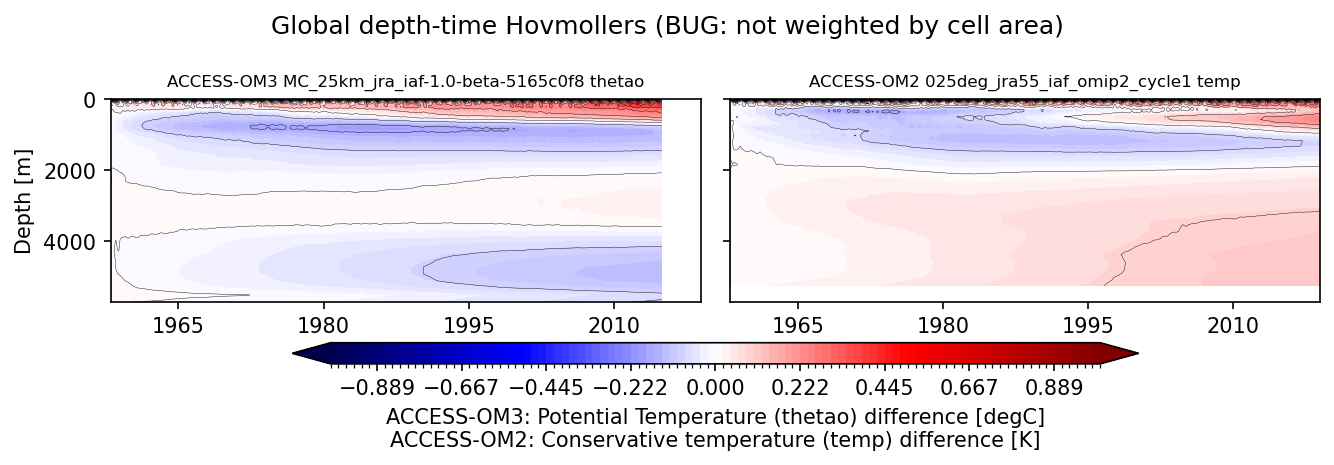

In [15]:
doplots(om3variable = "thetao",
        om2variable = "temp",
       pnum='none')

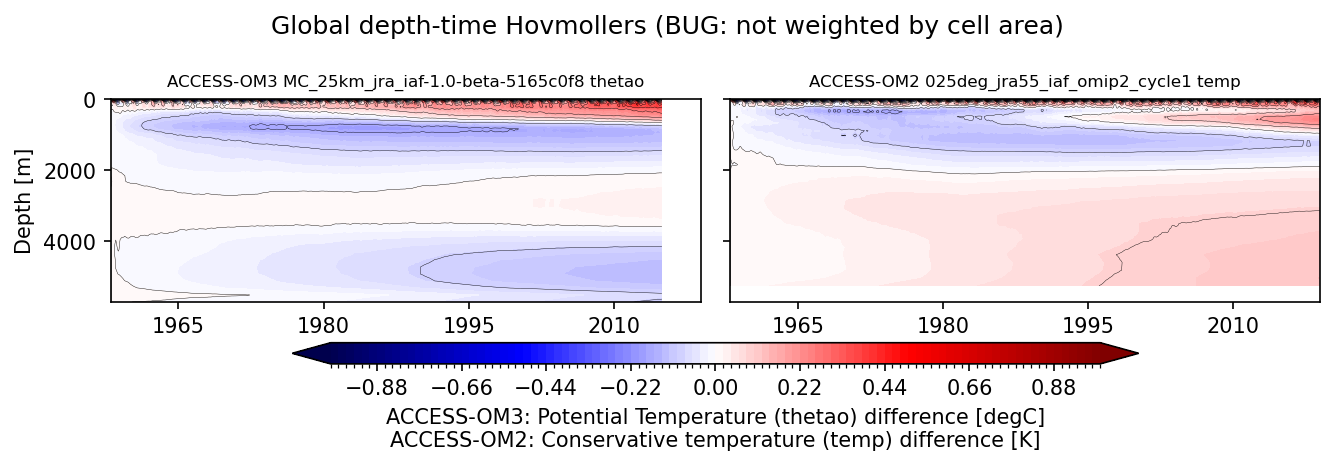

In [16]:
#cb: only exporting the one with a vmax specified -- temp
doplots(om3variable = "thetao",
        om2variable = "temp",
        vmax = 1,
       pnum='1')

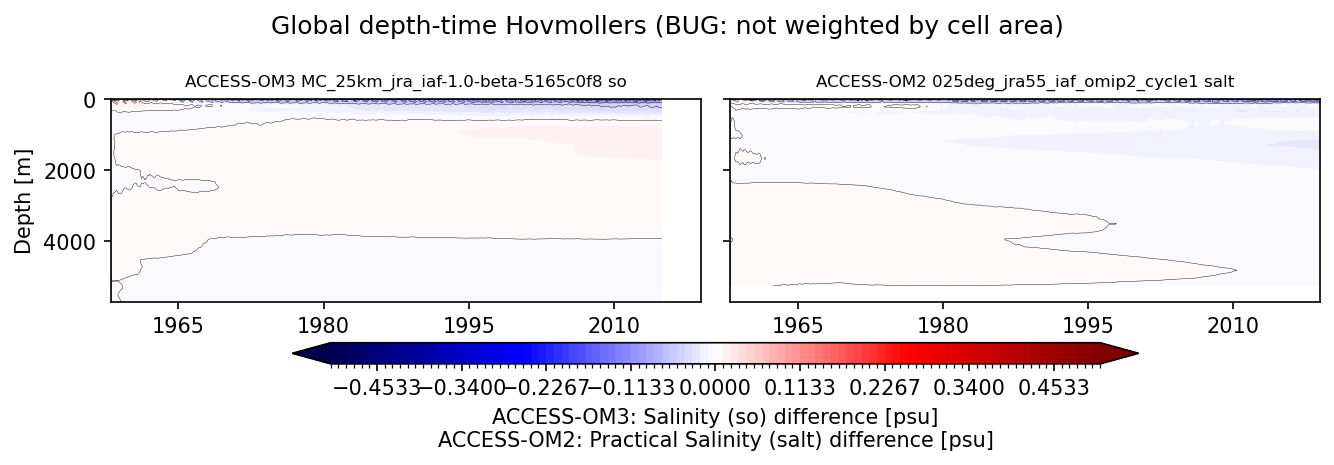

In [17]:
doplots(om3variable = "so",
        om2variable = "salt",
       pnum='none')

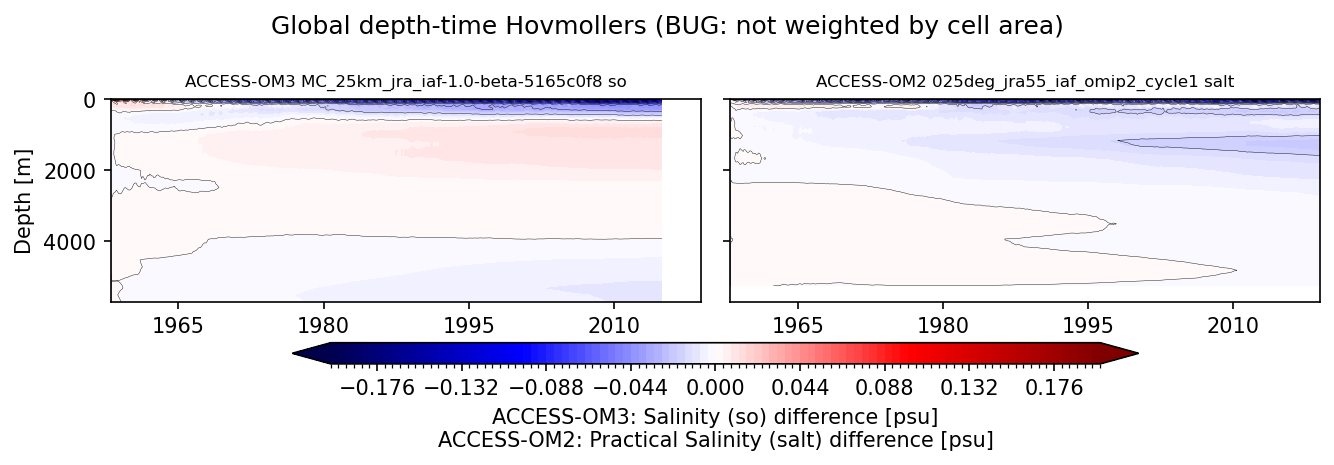

In [18]:
#cb: only exporting the one with a vmax specified -- salinity
doplots(om3variable = "so",
        om2variable = "salt",
        vmax = 0.2,
       pnum='2')

In [19]:
client.close()